# Using TensorFlow for Deep Dream
---------------------------------------

This recipe is an adapted version of the official TensorFlow [Deep Dream tutorial](https://www.tensorflow.org/tutorials/generative/deepdream)

At the origin, this technique was used to better understand how a CNN sees.


> Note: Visit the Google AI blog post [Inceptionism: Going Deeper into Neural Networks](https://ai.googleblog.com/2015/06/inceptionism-going-deeper-into-neural.html) written by Alexander Mordvintsev.


## Import Libraries
We'll start with by loading the necessary libraries.

In [1]:
import numpy as np
import PIL.Image
import imageio
import matplotlib.pyplot as plt
import matplotlib as mpl

import tensorflow as tf

import IPython.display as display

## Prepare the image to dreamify

In [2]:
# To execute if the code is executed on Collab
from google.colab import drive
drive.mount('/content/drive')

path = 'drive/My Drive/tensorflow_cookbook-master/08_Convolutional_Neural_Networks/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Text(0.5, 1.0, 'Original Image')

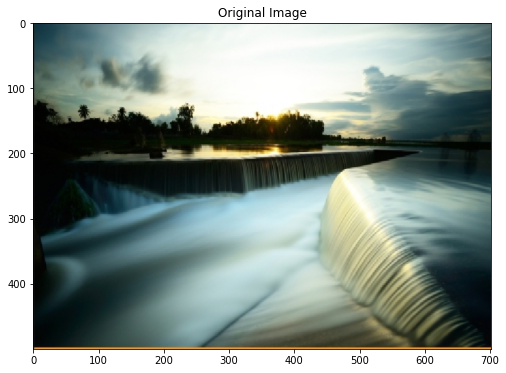

In [3]:
original_img_file = path + 'images/book_cover.jpg'

# Read the images
original_img = imageio.imread(original_img_file)

# Reshape to 500 max dimensions
new_shape = tf.cast((500, 500 * original_img.shape[1] / original_img.shape[0]), tf.int32)
original_img = tf.image.resize(original_img, new_shape, method='nearest').numpy()

# Display the image
mpl.rcParams['figure.figsize'] = (20,6)
mpl.rcParams['axes.grid'] = False

plt.imshow(original_img)
plt.title("Original Image")

## Load Inception model

We'll load the Inception model pre-trained on imagenet without the classification head. We will use the `tensorflow.keras.applications` API. 

> This API contains pre-trained deep learning models that can be used for prediction, feature extraction and fine-tuning.

In [11]:
inception_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')

The inception model architecture is quite large.

In [12]:
inception_model.summary()

In a convolutional neural network, the earlier layers extract basic features like edges, shapes, textures, etc whilst the deeper layers extract high-level features such as airplane, house, cloud, etc. 

To create a DeepDream image, we will focus on the layers where the convolutions are mixed. 
Now, we'll create the feature extraction model with the two mixed layers as outputs

In [13]:
names = ['mixed3', 'mixed5']
layers = [inception_model.get_layer(name).output for name in names]
deep_dream_model = tf.keras.Model(inputs=inception_model.input, outputs=layers)

## Define the loss function

The loss function returns the sum of all output layers.

In [14]:
def compute_loss(img, model):
  # Add a dimension to the image to have a batch of size 1.
  img_batch = tf.expand_dims(img, axis=0)

  # Apply the model to the image and get the outputs to retrieve the activation.
  layer_activations = model(img_batch)
  
  # Compute the loss for each layer
  losses = []
  for act in layer_activations:
    loss = tf.math.reduce_mean(act)
    losses.append(loss)

  return  tf.reduce_sum(losses)

## Gradient ascent

In DeepDream, we don't minimize the loss using gradient descent but we maximize the activation of these layers by maximizing their loss via gradient ascent.

So, we'll over-interpret the patterns that the model detects and we'll generate an inspiring visual content with surreal patterns.



In [15]:
# Normalize an image
def deprocess(img):
  img = 255*(img + 1.0)/2.0
  return tf.cast(img, tf.uint8)

# Display an image
def show(img):
  display.display(PIL.Image.fromarray(np.array(img)))


def run_deep_dream(image, steps=100, step_size=0.01):
    # Apply the Inception preprocessing
    image = tf.keras.applications.inception_v3.preprocess_input(image)
    image = tf.convert_to_tensor(image)

    loss = tf.constant(0.0)
    for n in tf.range(steps):
        # We use gradient tape to track TensorFlow computations
        with tf.GradientTape() as tape:
            # We use watch to force TensorFlow to track the image
            tape.watch(image)
            # We compute the loss
            loss = compute_loss(image, deep_dream_model)

        # Compute the gradients
        gradients = tape.gradient(loss, image)

        # Normalize the gradients.
        gradients /= tf.math.reduce_std(gradients) + 1e-8 
        
        # Perform the gradient ascent by directly adding the gradients to the image
        image = image + gradients*step_size
        image = tf.clip_by_value(image, -1, 1)

        # Display the intermediate image
        if (n % 100 ==0):
            display.clear_output(wait=True)
            show(deprocess(image))
            print ("Step {}, loss {}".format(n, loss))

    # Display the final image
    result = deprocess(image)
    display.clear_output(wait=True)
    show(result)

    return result

## Run Deep Dream

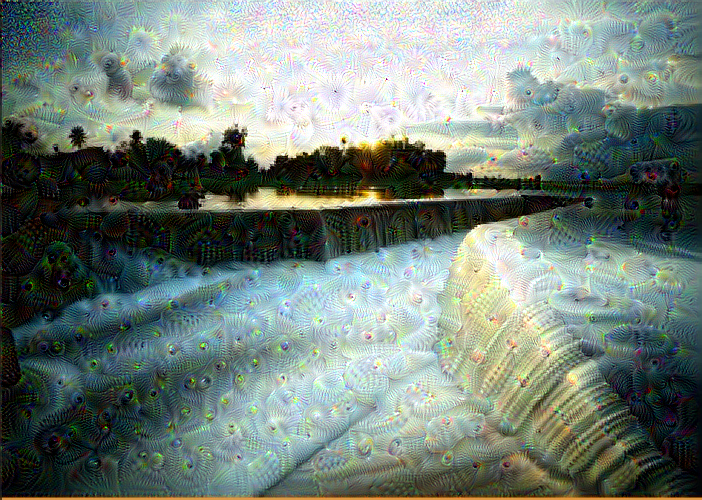

In [9]:
dream_img = run_deep_dream(image=original_img, 
                           steps=100, step_size=0.01)

The result is good but it could be better!

We notice that the image output is noisy, the patterns seem to be applied at the same granularity and the output is in low resolution.

To solve these problems, we can perform a gradient ascent on the same image resized multiple time.

## Run Deep Dream (Octave improvement)

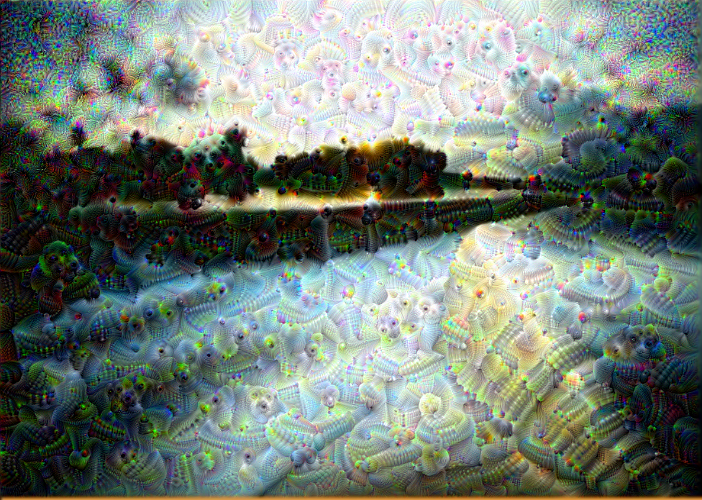

In [17]:
OCTAVE_SCALE = 1.30

image = tf.constant(np.array(original_img))
base_shape = tf.shape(image)[:-1]
float_base_shape = tf.cast(base_shape, tf.float32)

for n in range(-2, 3):
    # Increase the size of the image
    new_shape = tf.cast(float_base_shape*(OCTAVE_SCALE**n), tf.int32)
    print(new_shape)
    image = tf.image.resize(image, new_shape).numpy()

    # Apply deep dream
    image = run_deep_dream(image=image, steps=50, step_size=0.01)

# Display output
display.clear_output(wait=True)
image = tf.image.resize(image, base_shape)
image = tf.image.convert_image_dtype(image/255.0, dtype=tf.uint8)
show(image)